In [1]:
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [2]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue
# https://matplotlib.org/users/dflt_style_changes.html

# Extracting observed Conc.

## Define transect

In [3]:
obs_d13c = pd.read_table(path + 'observations/d13c_bulk_cal.tss')
obs_conc = pd.read_table(path + 'observations/conc_bulk_cal.tss')
p_b = pd.read_table(path + 'observations/p_bAve.tss')
obs_d13c.head()

,Jdays,DayMoYr,IDcal,d13C,d13C.SD
0,188,2016-04-05,B-188,-31.225186,0.640023
1,197,2016-04-14,B-197,-31.200375,0.303478
2,201,2016-04-18,B-201,-31.496359,0.390947
3,209,2016-04-26,B-209,-31.239331,0.542286
4,216,2016-05-03,B-216,-30.682124,0.434045


# Selecting indexes

In [4]:
gen = 'Gen1'
df3 = get_data(gen=gen)
# df4 = get_data(gen="Gen4")
counter = 0
print(len(df3))
# print( len(df4)

9802


In [5]:
df3["Gen"] = gen
# df4["Gen"] = "Gen4"
# df = pd.concat([df3, df4])
df = df3

In [6]:
# Index names
df['Name'] = df['Gen'] + "/" + df.index
df = df.set_index('Name')
# 'LHS_s2fix7/10/' in list(df.index)

In [7]:
# 'LHS_s2fix7/10/' in list(df.index)
# list(df)

In [8]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-blk'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-blk'])/2.0
df['epsilon_iso'] *= -1

cst = 0.40
df['Constraint'] = df.apply(WithIsoKGE, args=(cst,), axis=1)

In [9]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-blk'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-blk'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.7856671938254698, 0.5624784847441313)
Maximum Conc.
(0.779633598745622, 0.36008130938978367, 0.5077238884944065)
Maximum d13C
(0.9664222569512327, 0.70432567774303, 0.8186644665934912)


In [10]:
dfs = df[['Model', 'Gen',
          'dt_50_ref',
          'dt_50_ab',
#           'k_d',
          'epsilon_iso',
          'KGE-CONC-blk','KGE-d13C-blk',
          'KGE-CONC_out','KGE-d13C_out',
          'KGE-SM', 'KGE-d13C', 'Constraint'
          ]]

In [82]:
# Filter
dfs = dfs.loc[(dfs['Gen'] ==  gen)] # Try 25 with more data points

# Global
ff_c = dfs.loc[(dfs['KGE-SM'] > 0.45)] # Try 25 with more data points
ff_cd = dfs.loc[(dfs['KGE-SM'] > 0.1)  & (dfs['KGE-d13C'] >  0.7)]

# Soil
# ff = dfs.loc[(dfs['KGE-CONC-blk'] > 0.46)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.46) & (dfs['KGE-d13C-blk'] >  0.8)]

# Outlet
# ff = dfs.loc[(dfs['KGE-CONC_out'] > 0.20)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC_out'] > 0.20) & (dfs['KGE-d13C_out'] >  0.2)]


# ff = dfs.loc[(dfs['KGE-CONC-blk'] > 0.70)] # Try 25 with more data points
# ff_c = dfs.loc[(dfs['KGE-CONC-blk'] > 0.0) & (dfs['KGE-d13C-blk'] >  cst)]
print(len(dfs), len(ff_c), len(ff_cd))
ff_c.tail()

counter += 1

(9802, 63, 28)


### $\epsilon$ and DT50

In [83]:
# print(ff[['epsilon_iso']].mean())
print(ff_c[['epsilon_iso']].mean())
print(ff_c[['epsilon_iso']].std())

epsilon_iso   -2.484168
dtype: float64
epsilon_iso    1.347719
dtype: float64


In [84]:
# print(ff[['dt_50_ref']].mean())
print(ff_c[['dt_50_ref']].mean())
print(ff_c[['dt_50_ref']].std())

dt_50_ref    13.945765
dtype: float64
dt_50_ref    3.393962
dtype: float64


### Abiotic DT50

In [85]:
print(np.log(2.)/ff_c[['dt_50_ab']].mean()) 
print(np.log(2.)/ff_c[['dt_50_ab']].mean()-np.log(2.)/(ff_c[['dt_50_ab']].mean()+ff_c[['dt_50_ab']].std()))

dt_50_ab    0.003903
dtype: float64
dt_50_ab    0.000552
dtype: float64


In [86]:
var_df = ff_c.loc[(ff_c['Model']=='var')]
fix_df = ff_c.loc[(ff_c['Model']=='fix')]

In [87]:
nc = ff.index[(ff['Constraint'] == 'NC')].tolist() #[0]
wc = ff_c.index[(ff_c['Constraint'] == 'WC')].tolist() #[0]
print(len(nc), len(wc))

(54, 9)


In [88]:
# list(wc)

## Update path for Generation

In [89]:
# if counter < 2:
#     path += gen + '/'
# counter

# Extracting time series

In [90]:
def get_sets_bulk(name_list):
    # Get sim conc, convert mass, ug/g -> ug
    comp = ['nor', 'val', 'sou']
    sets = []
    for i in range(len(name_list)): # Set name
        transects = []
        for tran in comp:
            # Append masses and conc.
            filename = "resM_" + tran + "CONC_real.tss"
            conc_name = tran + 'CONC'
            sim = pd.read_table(path + name_list[i] + filename, 
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', conc_name],
                                header=None)
            
            mass_name = tran + "Mass"
            sim[mass_name] = sim[conc_name] * p_b['pbAve'] * 4.0 * 10.0 * 10**3
            transects.append(sim)
            
            # Append deltas
            filename = "resM_" + tran + "d13C_real.tss"
            delta_name = tran + 'd13C'
            sim = pd.read_table(path + name_list[i] + filename,
                                skiprows=4, delim_whitespace=True,
                                names=['Jdays', delta_name],
                                header=None)
            transects.append(sim)

        # Merge all transects
        blk = reduce(lambda x, y: pd.merge(x, y, on='Jdays'), transects)

        # Bulk concentration
        conc_name = 'Conc_blk' +  name_list[i][3:]
        blk[conc_name] = (blk['norCONC']*blk['norMass'] +
                          blk['valCONC']*blk['valMass'] +
                          blk['souCONC']*blk['souMass']
                          ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])

        iso_name = 'd13C_blk' +  name_list[i][3:]
        blk[iso_name] = (blk['nord13C']*blk['norMass'] +
                         blk['vald13C']*blk['valMass'] +
                         blk['soud13C']*blk['souMass']
                        ) / (blk['norMass'] + blk['valMass'] + blk['souMass'])
        
        blk = blk[0:121]
        blk = blk[['Jdays', conc_name, iso_name]]
        sets.append(blk)
    df = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)
    return df

In [91]:
# sets = get_sets_bulk(wc) # Returns sets merged
# sets.tail()

# Confidence interval calc.

In [92]:
def concat(row, plot):
    return plot.capitalize() + '-' + str(int(row['Jdays']))

In [93]:
def get_stats_bulk(df, measure, cst):
    n = len(np.array(df.iloc[0,1:]))
    df['mean'] = df.iloc[:,1:n+1].mean(axis=1)
    df['min'] = df.iloc[:,1:n+1].min(axis=1)
    df['max'] = df.iloc[:,1:n+1].max(axis=1)
    df['sem'] = df.iloc[:,1:n+1].sem(axis=1)
    df['sd'] = df.iloc[:,1:n+1].std(axis=1)
    df['high'] = df['mean'] + 2.*df['sd']
    df['low'] = df['mean'] - 2.*df['sd']
#     df['high'] = df.apply(get_ci, args=(n, 0.95, True), axis=1)
#     df['low'] = df.apply(get_ci, args=(n, 0.95, False), axis=1)
    if measure == "Conc":
        df['low'] = df.apply(check_negative, axis=1)
#     df['Trans'] = loc
#     df['Area'] = loc[0]
#     df['Level'] = level  # Composite or Detailed, 
    loc = "B"
    df['IDcal'] = df.apply (lambda row: concat(row, loc), axis=1)
    df['Type'] = df.apply(lambda row: ModelType(row, cst),axis=1)
    return df[['Jdays', 'mean', 'high', 'low', 'max', 'min', 'sd', 'IDcal', 'Type']]

In [94]:
# sets_wc.head()

In [95]:
sets_wc = get_sets_bulk(wc)
time_wc = sets_wc.filter(like="Jdays")

conc_wc = sets_wc.filter(like='Conc')
conc_fix = conc_wc.filter(like='fix')
conc_var = conc_wc.filter(like='var')

d13c_wc = sets_wc.filter(like='d13C')
d13c_fix = d13c_wc.filter(like='fix')
d13c_var = d13c_wc.filter(like='var')
# conc_nc = sets_nc.filter(like='Conc')

conc_tfix = pd.concat([time_wc, conc_fix], axis=1, join='inner')
conc_tvar = pd.concat([time_wc, conc_var], axis=1, join='inner')

d13c_tfix = pd.concat([time_wc, d13c_fix], axis=1, join='inner')
d13c_tvar = pd.concat([time_wc, d13c_var], axis=1, join='inner')

In [96]:
conc_tfix_all = get_stats_bulk(conc_tfix, 'Conc', 'Fix')
conc_tvar_all = get_stats_bulk(conc_tvar, 'Conc', 'Var')

d13c_tfix_all = get_stats_bulk(d13c_tfix, 'd13C', 'Fix')
d13c_tvar_all = get_stats_bulk(d13c_tvar, 'd13C', 'Var')

In [97]:
conc_tfix_all.head()
obs_d13c.head()

,Jdays,DayMoYr,IDcal,d13C,d13C.SD
0,188,2016-04-05,B-188,-31.225186,0.640023
1,197,2016-04-14,B-197,-31.200375,0.303478
2,201,2016-04-18,B-201,-31.496359,0.390947
3,209,2016-04-26,B-209,-31.239331,0.542286
4,216,2016-05-03,B-216,-30.682124,0.434045


### Merge simulated CI's with obs, (delta and Conc)

In [98]:
d13c_tvar_merged = pd.merge(d13c_tvar_all, obs_d13c, how='outer', on='IDcal')
conc_tvar_merged = pd.merge(conc_tvar_all, obs_conc, how='outer', on='IDcal')

d13c_tfix_merged = pd.merge(d13c_tfix_all, obs_d13c, how='outer', on='IDcal')
conc_tfix_merged = pd.merge(conc_tfix_all, obs_conc, how='outer', on='IDcal')
# nc_merged = pd.merge(nc_all, obs, how='outer', on='IDcal')

In [99]:
# wc_merged[20:25]
d13c_tvar_merged.tail(2)
# conc_tvar_merged.tail()

,Jdays_x,mean,high,low,max,min,sd,IDcal,Type,Jdays_y,DayMoYr,d13C,d13C.SD
119,285,-27.671984,-25.947126,-29.396843,-26.737083,-28.989186,0.862429,B-285,Var,NaN,NaN,NaN,NaN
120,286,-27.629454,-25.874642,-29.384265,-26.698952,-28.975518,0.877406,B-286,Var,NaN,NaN,NaN,NaN


In [100]:
# nc_merged.head()
# sets_all = pd.concat([nc_merged, wc_merged])

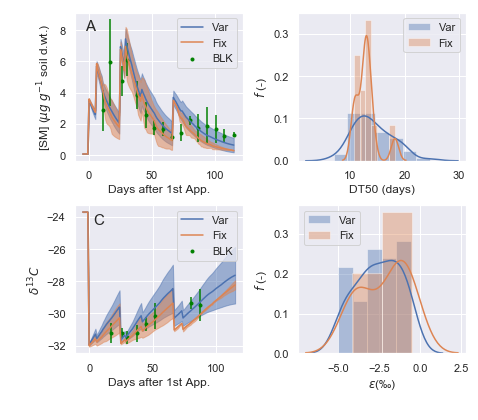

In [101]:
# sns.set(rc={'figure.figsize':(11.7, 8.27)})
# ES&T max width: 
# 1 column = 3.25in 
# 2 column = 7.0in 
sns.set_context("paper")
sns.set(rc={'figure.figsize':(7.0, 6.27)}) # Width, height, inches

fig, axes = plt.subplots(2, 2, sharex=False, sharey=False)

# Observed Conc
time = np.array(conc_tvar_merged['Jdays_x']-171)
arr_obs_conc = np.array(conc_tvar_merged['ug.g'])
arr_err = np.array(conc_tvar_merged['ug.g.SD'])

# Observed d13C
arr_obs_d13c = np.array(d13c_tvar_merged['d13C'])
arr_err_d13c = np.array(d13c_tvar_merged['d13C.SD'])

# Variable model
var_conc_mean = np.array(conc_tvar_merged['mean'])
var_conc_high = np.array(conc_tvar_merged['high'])
var_conc_low = np.array(conc_tvar_merged['low'])

var_d13c_mean = np.array(d13c_tvar_merged['mean'])
var_d13c_high = np.array(d13c_tvar_merged['high'])
var_d13c_low = np.array(d13c_tvar_merged['low'])

# Fix model
fix_conc_mean = np.array(conc_tfix_merged['mean'])
fix_conc_high = np.array(conc_tfix_merged['high'])
fix_conc_low = np.array(conc_tfix_merged['low'])

fix_d13c_mean = np.array(d13c_tfix_merged['mean'])
fix_d13c_high = np.array(d13c_tfix_merged['high'])
fix_d13c_low = np.array(d13c_tfix_merged['low'])


#####
# Left-Up
#####
# Var Conc
axes[0,0].plot(time, var_conc_mean, label='Var', c= "C0") # c= "red", marker='.', linestyle=':'
axes[0,0].legend(loc="upper right")
axes[0,0].fill_between(time, var_conc_high, var_conc_low, color= "C0", alpha=0.5)

# Var Conc
axes[0,0].plot(time, fix_conc_mean, label='Fix', c= "C1") # c= "red", marker='.', linestyle=':'
axes[0,0].legend(loc="upper right")
axes[0,0].fill_between(time, fix_conc_high, fix_conc_low,  color= "C1", alpha=0.5)

# Obs Conc
axes[0,0].errorbar(time, arr_obs_conc, arr_err, c= "green")
axes[0,0].scatter(time, arr_obs_conc, c= "green", marker='.', label="BLK")
axes[0,0].legend(loc="upper right")
# axes[0,0].set_ylabel("$\mu g$ $g^{-1}$")
axes[0,0].set_ylabel("[SM] ($\mu g$ $g^{-1}$ soil d.wt.)")
axes[0,0].set_xlabel("Days after 1st App.")

#############
# Left-Down
#############
# Var d13c
axes[1,0].plot(time, var_d13c_mean, label='Var', c= "C0") # c= "red", marker='.', linestyle=':'
axes[1,0].legend(loc="upper right")
axes[1,0].fill_between(time, var_d13c_high, var_d13c_low, color= "C0", alpha=0.5)

# Var d13c
axes[1,0].plot(time, fix_d13c_mean, label='Fix', c= "C1") # c= "red", marker='.', linestyle=':'
axes[1,0].legend(loc="upper right")
axes[1,0].fill_between(time, fix_d13c_high, fix_d13c_low,  color= "C1", alpha=0.5)

# Obs d13c
axes[1,0].errorbar(time, arr_obs_d13c, arr_err_d13c, c= "green")
axes[1,0].scatter(time, arr_obs_d13c, c= "green", marker='.', label="BLK")
axes[1,0].legend(loc="upper right")
axes[1,0].set_ylabel("$\delta ^{13}C$")
axes[1,0].set_xlabel("Days after 1st App.")

#############
# Right - UP
############
sns.distplot( var_df["dt_50_ref"] , color="C0", label="Var", ax=axes[0,1])
# sns.distplot( var_nc["dt_50_ref"] , color="red", label="Var - NC", ax=ax2)
sns.distplot( fix_df["dt_50_ref"] , color="C1", label="Fix", ax=axes[0,1])
# sns.distplot( var_wc["dt_50_ref"] , color="teal", label="Var - WC", ax=ax2)
axes[0,1].set_xlabel("DT50 (days)")
axes[0,1].set_ylabel("$f$ (-)")
axes[0,1].legend()

##############
# Right - Down
##############
sns.distplot( var_df['epsilon_iso'] , color="C0", label="Var", ax=axes[1,1])
sns.distplot( fix_df['epsilon_iso'] , color="C1", label="Fix", ax=axes[1,1])
axes[1,1].set_xlabel("$\epsilon$" + u'(\u2030)')
axes[1,1].set_ylabel("$f$ (-)")

# axes[0,0].annotate('A', fontsize=15,
#             xy=(60, 388), xycoords='figure pixels')
# axes[0,1].annotate('B', fontsize=15,
#             xy=(282, 388), xycoords='figure pixels')

# axes[1,0].annotate('C', fontsize=15,
#             xy=(60, 195), xycoords='figure pixels')
# axes[1,1].annotate('D', fontsize=15,
#             xy=(282, 195), xycoords='figure pixels')

axes[0,0].annotate('A', fontsize=15,
            xy=(-3, 8.), xycoords='data')

axes[0,1].annotate('B', fontsize=15,
            xy=(0, 0.055), xycoords='data')

axes[1,0].annotate('C', fontsize=15,
            xy=(3, -24.5), xycoords='data')

axes[1,1].annotate('D', fontsize=15,
            xy=(-4.9, 1.1), xycoords='data')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.33, hspace=0.30)
plt.legend()

# fig.savefig("Fig2_FitWC.pdf")

In [31]:
200-171

29

https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/

https://matplotlib.org/users/dflt_style_changes.html